# Chest-prediction

## PRELIMINARY ACTION !

⚠️ Please go to ➤ https://drive.google.com/file/d/1lLrHbpUQE-Kd-jZ68Uk7SFwawbzqf6Av/view?usp=drive_link

and download the dataset.

Put the zip file into your "*raw_data*" folder

## data loading

In [1]:
import numpy as np
import pandas as pd
import pdb

import os
from pathlib import Path
from PIL import Image

### Loading images

In [2]:
PROJECT_NAME = "chest-predictor" #to be adapted depending on the name of the Project Name in your system
NUMBER_OF_IMAGES = 3000 # nbr of images to be loaded or 'full' to load the entire dataset (+100k images)

In [3]:
USERNAME = os.environ.get('USER')

In [4]:
# I changed this so that it works on both windows and mac, but if it doesn't work uncomment the other one


# #LOCAL_DATA_PATH = Path(f"/Users/{USERNAME}/code/sachamagier/{PROJECT_NAME}/raw_data/resized_dataset")
LOCAL_DATA_PATH = Path(os.path.expanduser(f"~/code/sachamagier/{PROJECT_NAME}/raw_data/resized_dataset"))

In [5]:
print(f"LOCAL_DATA_PATH: {LOCAL_DATA_PATH}")

LOCAL_DATA_PATH: /home/rvnmll/code/sachamagier/chest-predictor/raw_data/resized_dataset


In [6]:
def loading_data():
    """This function either get all the images if the user set NUMBER_OF_IMAGES
    to 'full' or the number of imgaes otherwise """

    images_data = []

    # Define the path to the folder
    folder_path = f'../raw_data/resized_dataset/images/set_full/'


    # Get a list of all files in the folder
    file_list = os.listdir(folder_path)

    # Filter the list to only include image files
    image_files = [f for f in file_list if f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg')]


    # Loop through the first NUMBER_OF_IMAGES
    for i, image_file in enumerate(image_files):

        # Stop the loop after NUMBER_OF_IMAGES iterations
        if i == NUMBER_OF_IMAGES:
            break

        # Open the image file
        with Image.open(folder_path + image_file) as image:
            # Add the image to the list
            images_data.append((image_file, np.array(image)))

    return images_data

In [7]:
import urllib.request
import zipfile
import shutil


if LOCAL_DATA_PATH.is_dir():
    print("Load local data...")
    # loading data into data
    images_data = loading_data()
else:
    print("Unziping file and loading the data...")

    output_path = "../raw_data/resized_dataset.zip"
    # unzip the file
    with zipfile.ZipFile(output_path, "r") as zip_ref:
        for file_info in zip_ref.infolist():
            zip_ref.extract(file_info, "../raw_data/")

    if Path("../raw_data/__MACOSX").is_dir():
        # remove the __MACOSX folder if it exists
        shutil.rmtree("../raw_data/__MACOSX")

    # remove the zip file
    os.remove(output_path)
    images_data = loading_data()

print("data loaded.")

Load local data...
data loaded.


In [8]:
# Create a dataframe from the list of images and their indices
images_df = pd.DataFrame(images_data, columns=['Image Index', 'image'])

# Set the index of the dataframe to the 'Image Index' column
images_df = images_df.set_index('Image Index').sort_index(ascending=True)

In [9]:
images_df.shape

(3000, 1)

In [10]:
images_df['image'][0].shape

/tmp/ipykernel_72821/4042123707.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  images_df['image'][0].shape


(256, 256)

### Loading labels data

In [11]:
labels_df = pd.read_csv('../raw_data/resized_dataset/Data_Entry_2017.csv')

In [12]:
labels_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [13]:
unique_lab = labels_df['Finding Labels'].unique()

In [14]:
len(unique_lab)

836

### Merging Images with labels and creating a new DF

In [15]:
# Merge the image_df and labels_df dataframes on the 'Image Index' column
merged_df = pd.merge(images_df, labels_df[['Image Index', 'Finding Labels']], left_index=True, right_on='Image Index', how='inner')

# Rename the 'Finding Labels' column to 'labels'
merged_df = merged_df.rename(columns={'Finding Labels': 'labels'})

# Set the index of the dataframe to the 'Image Index' column
merged_df = merged_df.set_index('Image Index').sort_index(ascending=True)

In [16]:
merged_df.head()

,image,labels
Image Index,,
00000005_003.png,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",No Finding
00000006_000.png,"[[45, 43, 38, 34, 30, 27, 24, 21, 19, 17, 16, ...",No Finding
00000013_031.png,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Emphysema|Mass
00000017_002.png,"[[14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, ...",No Finding
00000018_000.png,"[[32, 30, 26, 24, 24, 23, 23, 22, 22, 22, 21, ...",No Finding


### droping the rows with images of shape (256, 256, 4)

In [17]:
# Find the images with shape (256, 256, 4)
images_with_shape_4 = [img for img in merged_df['image'] if np.shape(img) == (256, 256, 4)]

# Print the number of images with shape (256, 256, 4)
print(len(images_with_shape_4))


9


In [18]:
# Find the indices of the images with shape (256, 256, 4)
indices_to_drop = merged_df[merged_df['image'].apply(lambda x: np.shape(x) == (256, 256, 4))].index

# Drop the rows with the images with shape (256, 256, 4)
merged_df = merged_df.drop(indices_to_drop)

In [19]:
# Find the images with shape (256, 256, 4)
images_with_shape_4 = [img for img in merged_df['image'] if np.shape(img) == (256, 256, 4)]

# Print the number of images with shape (256, 256, 4)
print(len(images_with_shape_4))

0


### Encoding labels

In [20]:
# Define the list of labels
labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
           'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
           'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'No Finding']

# Create a new dataframe with one-hot encoded columns for the labels
one_hot_df = merged_df['labels'].str.get_dummies(sep='|')

# Concatenate the one-hot encoded dataframe with the original dataframe
merged_df = pd.concat([merged_df, one_hot_df], axis=1)


In [21]:
merged_df.columns

Index(['image', 'labels', 'Atelectasis', 'Cardiomegaly', 'Consolidation',
       'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'],
      dtype='object')

## Creating 'X' and 'y'

In [22]:
y = one_hot_df

In [23]:
X = merged_df['image']

In [24]:
X.info(memory_usage='deep')

<class 'pandas.core.series.Series'>
Index: 2991 entries, 00000005_003.png to 00030797_000.png
Series name: image
Non-Null Count  Dtype 
--------------  ----- 
2991 non-null   object
dtypes: object(1)
memory usage: 187.5 MB


In [25]:
X = np.array([np.reshape(img, (256, 256, 1)) for img in X])

In [26]:
X.shape

(2991, 256, 256, 1)

## First some imports as well as some accuracy and plot functions. We also already split X and y into train/val/test

In [27]:
#Imports
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2024-06-06 12:22:08.513689: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-06 12:22:08.566359: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-06 12:22:08.827181: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 12:22:08.827230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 12:22:08.868960: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [28]:
##### Splitting X and y in train/val/test #####

# First split: split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Second split: split training data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=69)

In [29]:
#import metrics
from sklearn.metrics import accuracy_score, hamming_loss, precision_score, recall_score

# Some extra metrics that we'll use to evaluate our model
def EMR(y_pred, y_test):
    """ Exact Match ratio, this takes the ratio of exact matches per samble.
    A prediction of a sample that accurately predicts ALL lables will be considered
    an Exact match, we cound all the exact matches and divide them by the sample
    amount to get the EM ratio
    """
    return np.all(y_pred == y_test, axis=1).mean()

def hamming_score_value(y_pred, y_test):
    """Proportion of the predicted correct labels to the total number (predicted and actual) of labels
    for that instance. Overall accuracy is the average across all instances.
    We use the hamming loss because it's the opposite of the hamming score, it reports
    how many times on average, the relevance of an example to a class label is incorrectly predicted.
    """
    return 1 - hamming_loss(y_pred, y_test)

def average_precision(y_pred, y_test):
    return precision_score(y_test, y_pred, average='samples', zero_division=0)
def average_recall(y_pred, y_test):
    return recall_score(y_test, y_pred, average='samples')

def evaluating_model(y_pred, y_test):
    print('Exact Match Ratio:', EMR(y_pred, y_test)),
    print('Hamming Score:', hamming_score_value(y_pred, y_test)),
    print('Average Precision:', average_precision(y_pred, y_test)),
    print('Average Recall:', average_recall(y_pred, y_test))


In [38]:
## We use a plot function to see the accuracy for the model
import matplotlib.pyplot as plt
def plot_history(history, title='', axs=None, exp_name=""):
    """We use a plot function to see the accuracy for the model, if you want another metric,
    edit the code in the ax2.plot part"""
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)



/home/rvnmll/.pyenv/versions/3.10.6/envs/chest-predictor/lib/python3.10/site-packages/IPython/core/completerlib.py:149: UserWarning: using rootmodules_cache requires you to install the `pickleshare` library.
  ip.db['rootmodules_cache'] = rootmodules_cache



Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)



/home/rvnmll/.pyenv/versions/3.10.6/envs/chest-predictor/lib/python3.10/site-packages/IPython/core/completerlib.py:149: UserWarning: using rootmodules_cache requires you to install the `pickleshare` library.
  ip.db['rootmodules_cache'] = rootmodules_cache
/home/rvnmll/.pyenv/versions/3.10.6/envs/chest-predictor/lib/python3.10/site-packages/IPython/core/completerlib.py:149: UserWarning: using rootmodules_cache requires you to install the `pickleshare` library.
  ip.db['rootmodules_cache'] = rootmodules_cache



Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)



/home/rvnmll/.pyenv/versions/3.10.6/envs/chest-predictor/lib/python3.10/site-packages/IPython/core/completerlib.py:149: UserWarning: using rootmodules_cache requires you to install the `pickleshare` library.
  ip.db['rootmodules_cache'] = rootmodules_cache


In [31]:

#Image  and training parameters
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 32
NUM_CLASSES = 15
PATIENCE = 10

## Creating a simple model

In [32]:
"""Here I already define the early stopping and checkpoint, since it will be the same for most of the models"""
models_dir = '../models' #This is where the best models will be saved

# Ensure that the directory exists
os.makedirs(models_dir, exist_ok=True)

es = EarlyStopping(monitor='val_loss',
                   patience=PATIENCE,
                   verbose=0,
                   restore_best_weights=True)

# You can include a checkpoint to your model if you want the model to periodically save the best model. This can be useful if the kernel
# crashes because then the model is not lost

model_checkpoint = ModelCheckpoint(filepath= os.path.join(models_dir, 'simple_model_best.h5'),
                                   save_best_only=True,
                                   monitor='val_loss',
                                   mode='min')


In [35]:
# Define a simple model
def simple_model():

    model = Sequential()
    model.add(Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH,1)))

    model.add(Conv2D(16, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(3))

    model.add(Conv2D(32, kernel_size=5, activation="relu"))
    model.add(MaxPooling2D(3))

    model.add(Conv2D(32, kernel_size=3, activation="relu"))
    model.add(MaxPooling2D(3))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(NUM_CLASSES, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [36]:
s_model = simple_model()
s_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 1)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 84, 84, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 80, 80, 32)        12832     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 26, 26, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 32)       

In [37]:
# Train the model
history = s_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=BATCH_SIZE,
    callbacks=[es])

Epoch 1/10
60/60 [==============================] - 8s 113ms/step - loss: 0.2637 - accuracy: 0.4673 - val_loss: 0.2215 - val_accuracy: 0.5511
Epoch 2/10
60/60 [==============================] - 7s 112ms/step - loss: 0.2235 - accuracy: 0.5311 - val_loss: 0.2213 - val_accuracy: 0.5511
Epoch 3/10
60/60 [==============================] - 9s 145ms/step - loss: 0.2220 - accuracy: 0.5316 - val_loss: 0.2221 - val_accuracy: 0.5511
Epoch 4/10
60/60 [==============================] - 9s 145ms/step - loss: 0.2204 - accuracy: 0.5301 - val_loss: 0.2189 - val_accuracy: 0.5532
Epoch 5/10
60/60 [==============================] - 8s 142ms/step - loss: 0.2171 - accuracy: 0.5243 - val_loss: 0.2162 - val_accuracy: 0.5511
Epoch 6/10
60/60 [==============================] - 9s 158ms/step - loss: 0.2152 - accuracy: 0.5243 - val_loss: 0.2183 - val_accuracy: 0.5365
Epoch 7/10
60/60 [==============================] - 13s 210ms/step - loss: 0.2117 - accuracy: 0.5233 - val_loss: 0.2183 - val_accuracy: 0.5386
Epoch

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

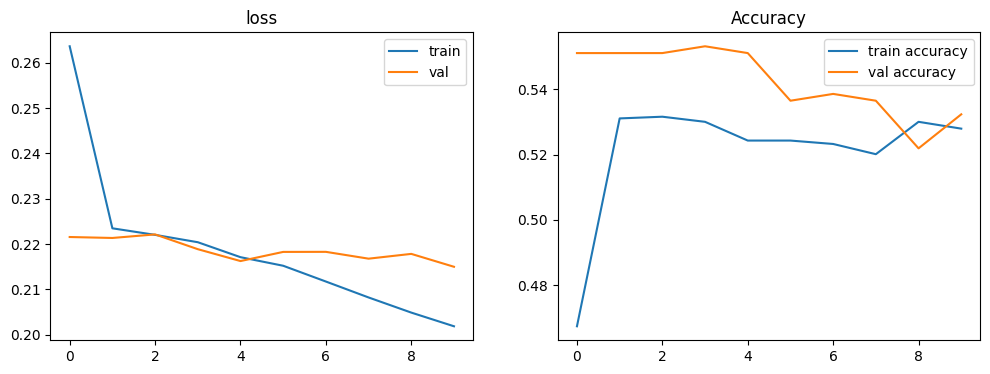

In [44]:
plot_history(history)

In [39]:
test_loss, test_accuracy = s_model.evaluate(X_test, y_test)
val_loss, val_accuracy = s_model.evaluate(X_val, y_val)
print('val accuracy:', val_accuracy)
print('test accuracy:', test_accuracy)

15/15 [==============================] - 0s 31ms/step - loss: 0.2150 - accuracy: 0.5324
val accuracy: 0.5323590636253357
test accuracy: 0.49916526675224304


In [40]:
y_pred = s_model.predict(X_test)

19/19 [==============================] - 1s 31ms/step


In [41]:
y_pred[0]

array([0.1949842 , 0.0471625 , 0.02844406, 0.00854159, 0.11567116,
       0.02332456, 0.02638437, 0.00273205, 0.17257589, 0.08464603,
       0.44317847, 0.06318879, 0.05374875, 0.00983633, 0.03629851],
      dtype=float32)

In [42]:
y.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
Image Index,,,,,,,,,,,,,,,
00000005_003.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
00000006_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
00000013_031.png,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
00000017_002.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
00000018_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [43]:
#Because we need binary results to evaluate the model we'll put a threshold
#that will transform the values to either 0 or 1, changing the threshold will also change the metric results

threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)

print(evaluating_model(y_pred_binary, y_test))

Exact Match Ratio: 0.3606010016694491
Hamming Score: 0.9230940456316082
Average Precision: 0.3622704507512521
Average Recall: 0.3614357262103506
None


## We train a more complex model to see how our scores change 

In [45]:
# Define a more complex model
model = Sequential()
model.add(Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH,1)))

model.add(Conv2D(16, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
#model.add(Dropout(0.3))

model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
#model.add(Dropout(0.3))

model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
#model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
#model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.3))

model.add(Dense(25, activation='relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.3))

model.add(Dense(NUM_CLASSES, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])


In [138]:
# model_checkpoint = ModelCheckpoint(filepath= os.path.join(models_dir, 'better_model.h5'),
#                                    save_best_only=True,
#                                    monitor='val_loss',
#                                    mode='min')


In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 1)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      160       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 32)     

In [47]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=BATCH_SIZE,
    callbacks=[es])

Epoch 1/30
60/60 [==============================] - 26s 403ms/step - loss: 0.7068 - accuracy: 0.1683 - val_loss: 0.7991 - val_accuracy: 0.0543
Epoch 2/30
60/60 [==============================] - 22s 370ms/step - loss: 0.5979 - accuracy: 0.3837 - val_loss: 0.7162 - val_accuracy: 0.0960
Epoch 3/30
60/60 [==============================] - 25s 427ms/step - loss: 0.4753 - accuracy: 0.5076 - val_loss: 0.4233 - val_accuracy: 0.5511
Epoch 4/30
60/60 [==============================] - 26s 430ms/step - loss: 0.3439 - accuracy: 0.5410 - val_loss: 0.3260 - val_accuracy: 0.5511
Epoch 5/30
60/60 [==============================] - 25s 421ms/step - loss: 0.2673 - accuracy: 0.5389 - val_loss: 0.3864 - val_accuracy: 0.2610
Epoch 6/30
60/60 [==============================] - 26s 434ms/step - loss: 0.2210 - accuracy: 0.5609 - val_loss: 0.2298 - val_accuracy: 0.5511
Epoch 7/30
60/60 [==============================] - 24s 407ms/step - loss: 0.1950 - accuracy: 0.5646 - val_loss: 0.2319 - val_accuracy: 0.5511

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

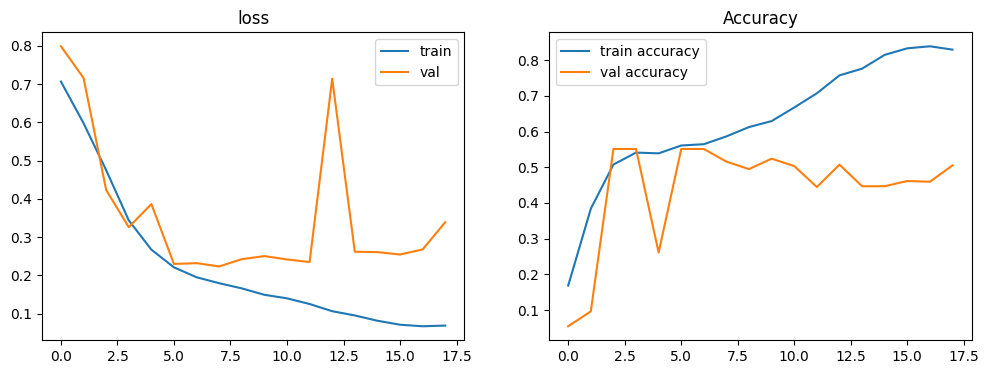

In [48]:
plot_history(history)

In [49]:
y_pred = model.predict(X_test)

19/19 [==============================] - 1s 65ms/step


In [50]:
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)

print(evaluating_model(y_pred_binary, y_test))

Exact Match Ratio: 0.2637729549248748
Hamming Score: 0.9195325542570951
Average Precision: 0.2671118530884808
Average Recall: 0.2651641624930439
None


## I try also some vgg16 based architectures to see if the performance increases 

In [35]:
def vg16_based__simpler():
    model = Sequential()

    model.add(Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH,1)))

    model.add(Conv2D(32, kernel_size=3, padding = 'same', activation='relu'))
    model.add(Conv2D(32, kernel_size=3, padding = 'same', activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(64, kernel_size=3, padding = 'same', activation='relu'))
    model.add(Conv2D(64, kernel_size=3, padding = 'same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(128, kernel_size=3, padding = 'same', activation='relu'))
    model.add(Conv2D(64, kernel_size=3, padding = 'same', activation='relu'))
    model.add(Conv2D(64, kernel_size=3, padding = 'same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(128, kernel_size=3, padding = 'same', activation='relu'))
    model.add(Conv2D(128, kernel_size=3, padding = 'same', activation='relu'))
    model.add(Conv2D(64, kernel_size=3, padding = 'same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(128, kernel_size=3, padding = 'same', activation='relu'))
    model.add(Conv2D(64, kernel_size=3, padding = 'same', activation='relu'))
    model.add(Conv2D(64, kernel_size=3, padding = 'same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation='relu', name = 'fc1'))
    model.add(Dense(128, activation='relu', name = 'fc2'))
    model.add(Dense(25, activation='relu', name = 'fc3'))
    model.add(Dense(NUM_CLASSES, activation='sigmoid', name = 'ouput'))

    model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
    return model

In [36]:
model = vg16_based__simpler()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 1)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 conv2d_14 (Conv2D)          (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 conv2d_16 (Conv2D)          (None, 128, 128, 64)      36928     
                                                      

In [37]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    callbacks=[es])

Epoch 1/30
15/15 [==============================] - 147s 9s/step - loss: 0.6285 - accuracy: 0.1892 - val_loss: 0.4267 - val_accuracy: 0.0292
Epoch 2/30
15/15 [==============================] - 162s 11s/step - loss: 0.3358 - accuracy: 0.3988 - val_loss: 0.2679 - val_accuracy: 0.5511
Epoch 3/30
15/15 [==============================] - 159s 11s/step - loss: 0.2451 - accuracy: 0.5311 - val_loss: 0.2347 - val_accuracy: 0.5511
Epoch 4/30
15/15 [==============================] - 160s 11s/step - loss: 0.2266 - accuracy: 0.5311 - val_loss: 0.2243 - val_accuracy: 0.5511
Epoch 5/30
15/15 [==============================] - 165s 11s/step - loss: 0.2223 - accuracy: 0.5311 - val_loss: 0.2216 - val_accuracy: 0.5511
Epoch 6/30
15/15 [==============================] - 152s 10s/step - loss: 0.2213 - accuracy: 0.5311 - val_loss: 0.2256 - val_accuracy: 0.5511
Epoch 7/30
15/15 [==============================] - 171s 12s/step - loss: 0.2219 - accuracy: 0.5311 - val_loss: 0.2269 - val_accuracy: 0.5511
Epoch 8

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)

print(evaluating_model(y_pred_binary, y_test))

In [86]:
## If we use a virtual machine we can just use the original architecture, which is bellow but this might be an overkill
def vg16_architecture():
    model = Sequential()

    model.add(Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH,1)))

    model.add(Conv2D(64, kernel_size=3, padding = 'same', activation='relu'))
    model.add(Conv2D(64, kernel_size=3, padding = 'same', activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(128, kernel_size=3, padding = 'same', activation='relu'))
    model.add(Conv2D(128, kernel_size=3, padding = 'same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(256, kernel_size=3, padding = 'same', activation='relu'))
    model.add(Conv2D(256, kernel_size=3, padding = 'same', activation='relu'))
    model.add(Conv2D(256, kernel_size=3, padding = 'same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(512, kernel_size=3, padding = 'same', activation='relu'))
    model.add(Conv2D(512, kernel_size=3, padding = 'same', activation='relu'))
    model.add(Conv2D(512, kernel_size=3, padding = 'same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(512, kernel_size=3, padding = 'same', activation='relu'))
    model.add(Conv2D(512, kernel_size=3, padding = 'same', activation='relu'))
    model.add(Conv2D(512, kernel_size=3, padding = 'same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())

    model.add(Dense(256, activation='relu', name = 'fc1'))
    model.add(Dense(128, activation='relu', name = 'fc2'))
    model.add(Dense(25, activation='relu', name = 'fc3'))
    model.add(Dense(NUM_CLASSES, activation='sigmoid', name = 'ouput'))

    model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
    return model

In [87]:
model = vg16_based__model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 1)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 256, 256, 64)      640       
                                                                 
 conv2d_14 (Conv2D)          (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 128, 128, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 128, 128, 128)     147584    
                                                      

In [1]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    callbacks=[es])

NameError: name 'model' is not defined

## We can also try to use a transfer model


The model takes as input RGB images, and we have only gray scale images. First we need to transform X to RGB format.

In [51]:
import cv2

# Create an empty list to store the transformed images
X_rgb = []

# Loop through each image in X_train
for img in X:
    # Convert BGR image to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Append the transformed image to the list
    X_rgb.append(img_rgb)

# Convert the list of images to a numpy array
X_rgb = np.array(X_rgb)

Now we do a train split again but with the correct format. 

In [52]:
##### Splitting X and y in train/val/test #####

# First split: split data into training and test sets (80% train, 20% test)
X_train_rgb, X_test_rgb, y_train_rgb, y_test_rgb = train_test_split(X_rgb, y, test_size=0.2, random_state=69)

# Second split: split training data into training and validation sets (80% train, 20% validation)
X_train_rgb, X_val_rgb, y_train_rgb, y_val_rgb = train_test_split(X_train_rgb, y_train_rgb, test_size=0.2, random_state=69)

In [53]:
from tensorflow.keras.applications.vgg16 import VGG16

def load_model():

    model = VGG16(weights="imagenet", include_top=False, input_shape=X_train_rgb[0].shape)

    return model

In [54]:
model = load_model()

model.summary()

58889256/58889256 [==============================] - 20s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                             

In [56]:
def set_nontrainable_layers(model):

    # Set the first layers to be untrainable
    model.trainable = False

    return model

model = set_nontrainable_layers(model)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [63]:
def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    base_model = set_nontrainable_layers(model)
    flatten_layer = Flatten()
    dense_layer = Dense(256, activation='relu')
    # dense_layer = Dense(500, activation='relu')

    prediction_layer = Dense(NUM_CLASSES, activation='sigmoid')


    model = Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])
    return model

In [64]:
from tensorflow.keras.optimizers import Adam

def build_model():
    model = load_model()
    model = add_last_layers(model)

    opt = Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [65]:
transfer_model = build_model()
transfer_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 32768)             0         
                                                                 
 dense_13 (Dense)            (None, 256)               8388864   
                                                                 
 dense_14 (Dense)            (None, 15)                3855      
                                                                 
Total params: 23107407 (88.15 MB)
Trainable params: 8392719 (32.02 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [66]:
from tensorflow.keras.applications.vgg16 import preprocess_input

In [67]:
X_train_rgb = preprocess_input(X_train_rgb)
X_val_rgb = preprocess_input(X_val_rgb)
X_test_rgb = preprocess_input(X_test_rgb)

In [68]:
es = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 5,
                   verbose = 1,
                   restore_best_weights = True)

In [70]:
history = model.fit(X_train_rgb, y_train_rgb,
                    validation_data=(X_val_rgb, y_val_rgb),
                    epochs=10,
                    batch_size=16,
                    callbacks=[es])

: 

Evaluate the customized VGG16 accuracy on the test set. Did we improve?

In [ ]:
res_vgg = model.evaluate(X_test_rgb, y_test_rgb)

test_accuracy_vgg = res_vgg[-1]


print(f"test_accuracy_vgg = {round(test_accuracy_vgg,2)*100} %")

print(f"test_accuracy = {round(test_accuracy,2)*100} %")

print(f'Chance level: {1./num_classes*100:.1f}%')